# Universal Segmentation with OneFormer

Paper: https://arxiv.org/abs/2211.06220

## Install required libraries

In [1]:
!pip install transformers pillow torch==1.13.1+cpu openvino==2023.0.0.dev20230407


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import warnings
from dataclasses import fields
import requests
from collections import defaultdict
from pathlib import Path

from transformers import OneFormerProcessor, OneFormerForUniversalSegmentation
from transformers.models.oneformer.modeling_oneformer import OneFormerForUniversalSegmentationOutput
from PIL import Image
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from openvino.tools import mo
from openvino.runtime import serialize, Core

In [3]:
onnx_path = Path("oneformer.onnx")
ir_path = Path("oneformer.xml")

## Load OneFormer fine-tuned on COCO for universal segmentation

In [4]:
processor = OneFormerProcessor.from_pretrained("shi-labs/oneformer_coco_swin_large")
model = OneFormerForUniversalSegmentation.from_pretrained(
    "shi-labs/oneformer_coco_swin_large"
)
id2label = model.config.id2label

/home/itrushkin/.virtualenvs/oneformer/lib/python3.8/site-packages/transformers/models/oneformer/image_processing_oneformer.py:417: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


In [5]:
if not onnx_path.exists():
    dummy_input = (
        {
            "pixel_values": torch.randn(1, 3, 800, 1066),
            "task_inputs": torch.randn(1, 77),
            "pixel_mask": torch.randn(1, 800, 1066),
        },
    )
    warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
    output_names = [field.name for field in fields(OneFormerForUniversalSegmentationOutput)]
    torch.onnx.export(
        model,
        dummy_input,
        onnx_path,
        input_names=list(dummy_input[0].keys()),
        output_names=['class_queries_logits', 'masks_queries_logits'],
        dynamic_axes={'pixel_values': [2, 3], 'pixel_mask': [1, 2]},
        opset_version=16
    )

/home/itrushkin/.virtualenvs/oneformer/lib/python3.8/site-packages/torch/onnx/utils.py:2040: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input pixel_values
  warnings.warn(
/home/itrushkin/.virtualenvs/oneformer/lib/python3.8/site-packages/torch/onnx/utils.py:2040: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input pixel_mask
  warnings.warn(
/home/itrushkin/.virtualenvs/oneformer/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/itrushkin/.virtualenvs/oneformer/lib/python3.8/site-packages/torch/onnx/_internal/jit_utils.py:258: Use

## Convert the model to OpenVINO IR format

## Prepare the image

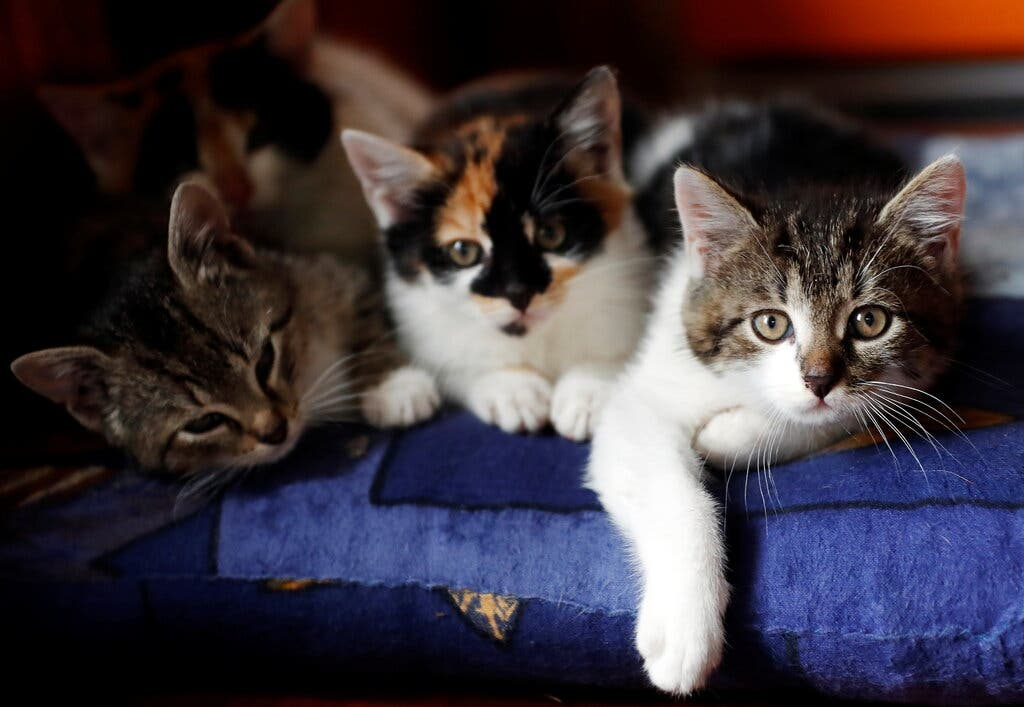

In [6]:
url = (
    'https://static01.nyt.com/images/2022/11/29/science/00tb-cats1/merlin_194921559_c9e53b04-169a-4144-bd76-9ec2d987c35c-jumbo.jpg?quality=75&auto=webp'
)
image = Image.open(requests.get(url, stream=True).raw)
image

## Compile OpenVINO model

In [7]:
if not ir_path.exists():
    model = mo.convert_model("oneformer.onnx")
    serialize(model, ir_path)

In [8]:
core = Core()
# Read the model from files.
model = core.read_model(model=ir_path)

# Compile the model for a specific device.
model = core.compile_model(model=model, device_name="CPU")

In [9]:
def prepare_inputs(image, task):
    inputs = processor(image, [task], return_tensors="pt")
    converted =  {
        'pixel_values': inputs['pixel_values'],
        'task_inputs': inputs['task_inputs']
    }
    return converted

In [10]:
def process_output(d):
    z = [next(iter(s)) for s in d.names()]
    class_queries_logits = torch.tensor(d[0])
    masks_queries_logits = torch.tensor(d[1])
    hf_kwargs = {
        'class_queries_logits': class_queries_logits,
        'masks_queries_logits': masks_queries_logits
    }
    return OneFormerForUniversalSegmentationOutput(**hf_kwargs)

## Semantic segmentation

In [11]:
import numpy as np

inputs = prepare_inputs(image, 'semantic')

outputs = model(inputs)

hf_output = process_output(outputs)
# model predicts class_queries_logits of shape `(batch_size, num_queries)`
# and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
class_queries_logits = hf_output.class_queries_logits
masks_queries_logits = hf_output.masks_queries_logits
# print(class_queries_logits)
# print(masks_queries_logits)

# you can pass them to processor for semantic postprocessing
predicted_semantic_map = processor.post_process_semantic_segmentation(
    hf_output, target_sizes=[image.size[::-1]]
)

RuntimeError: Check 'false' failed at src/inference/src/infer_request.cpp:71:
Check 'false' failed at src/inference/src/infer_request.cpp:63:
Can't set input blob with name: pixel_values, because model input (shape=[1,3,800,1066]) and blob (shape=(1.3.800.1158)) are incompatible



In [ ]:
def draw_semantic_segmentation(segmentation):
    # get the used color map
    viridis = plt.get_cmap('viridis', torch.max(segmentation))
    # get all the unique numbers
    labels_ids = torch.unique(segmentation).tolist()
    fig, ax = plt.subplots()
    ax.imshow(segmentation)
    handles = []
    for label_id in labels_ids:
        label = id2label[label_id]
        color = viridis(label_id)
        handles.append(mpatches.Patch(color=color, label=label))
    ax.legend(handles=handles)

draw_semantic_segmentation(predicted_semantic_map[0])

## Instance Segmentation

In [ ]:
inputs = prepare_inputs(image, 'instance')
outputs = model(inputs)

hf_output = process_output(outputs)
# model predicts class_queries_logits of shape `(batch_size, num_queries)`
# and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
class_queries_logits = hf_output.class_queries_logits
masks_queries_logits = hf_output.masks_queries_logits

# you can pass them to processor for instance postprocessing
predicted_instance_map = processor.post_process_instance_segmentation(
    hf_output, target_sizes=[image.size[::-1]]
)[0]

In [ ]:
def draw_instance_segmentation(segmentation, segments_info):
    # get the used color map
    viridis = plt.get_cmap('viridis', torch.max(segmentation))
    fig, ax = plt.subplots()
    ax.imshow(segmentation)
    instances_counter = defaultdict(int)
    handles = []
    # for each segment, draw its legend
    for segment in segments_info:
        segment_id = segment['id']
        segment_label_id = segment['label_id']
        segment_label = id2label[segment_label_id]
        label = f"{segment_label}-{instances_counter[segment_label_id]}"
        instances_counter[segment_label_id] += 1
        color = viridis(segment_id)
        handles.append(mpatches.Patch(color=color, label=label))
        
    ax.legend(handles=handles)
    plt.savefig('instance.png')

draw_instance_segmentation(**predicted_instance_map)

## Panoptic Segmentation

In [ ]:
inputs = prepare_inputs(image, 'panoptic')
outputs = model(inputs)
outputs = process_output(outputs)
# model predicts class_queries_logits of shape `(batch_size, num_queries)`
# and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits

# you can pass them to processor for panoptic postprocessing
predicted_panoptic_map = processor.post_process_panoptic_segmentation(
    outputs, target_sizes=[image.size[::-1]]
)[0]

In [ ]:
def draw_panoptic_segmentation(segmentation, segments_info):
    # get the used color map
    viridis = plt.get_cmap('viridis', torch.max(segmentation)+1)
    fig, ax = plt.subplots()
    ax.imshow(segmentation)
    instances_counter = defaultdict(int)
    handles = []
    # for each segment, draw its legend
    for segment in segments_info:
        segment_id = segment['id']
        segment_label_id = segment['label_id']
        segment_label = id2label[segment_label_id]
        label = f"{segment_label}-{instances_counter[segment_label_id]}"
        instances_counter[segment_label_id] += 1
        color = viridis(segment_id)
        handles.append(mpatches.Patch(color=color, label=label))
        
    ax.legend(handles=handles)
    plt.savefig('panoptic.png')

draw_panoptic_segmentation(**predicted_panoptic_map)